# ENSO_asymmetry: Skewness of SST Anomalies in the Central Equatorial Pacific  

Computes the skewness of sea surface temperature anomalies (SSTA) in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W). The skewness indicates the asymmetry of the distribution of SST anomalies, where a positive skew suggests that positive anomalies (El Niño events) reach larger values than negative anomalies (La Niña events), and vice versa.

## Datasets Used for Asymmetry Comparison  

The following reference datasets are used to evaluate the asymmetry of ENSO-related SST anomalies in model simulations:  

- **TropFlux (1979–2018)**: The primary dataset for comparison, designed for analysing tropical climate variability, including surface fluxes and SST anomalies.  

Additional datasets include:  
- **20CRv2 (1871–2012)**: A historical reanalysis product providing long-term atmospheric data using surface pressure observations.  
- **ERA-Interim (1979–2018)**: A high-resolution reanalysis dataset offering consistent atmospheric and surface variable estimates.  
- **ERSSTv5 (1854–2018)**: A globally gridded dataset optimised for climate monitoring, including ENSO-related SST anomaly studies.  
- **HadISST (1870–2018)**: A historical dataset combining SST and sea ice observations with reconstructions.  
- **NCEP2 (1979–2018)**: A second-generation reanalysis product delivering improved atmospheric and surface data globally.

## Dask Cluster 

Start a cluster with multiple cores 

In [ ]:
from dask.distributed import Client, progress
client = Client()
client

## Datasets

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='tos',
#     project='CMIP6',
#     mip="Omon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# )
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
}

## Add Ancillary files

In [3]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics, meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt
from scipy.stats import skew


In [7]:
def preprocess(cube):
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube,period='monthly')
    cube = detrend(cube, dimension="time", method="linear")
    cube = regrid(cube, target_grid="1x1", scheme="linear")

    return cube
    
def diag1(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}  
    cube = extract_region(cube, **nino34_latext_region)
    cube = area_statistics(cube,operator='mean')
    return skew(cube.data, axis=0)

def compute(obs, mod):
    return abs((mod-obs)/obs)*100

In [8]:

model_datasets_prep = {name: preprocess(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: preprocess(dataset) for name, dataset in obs_datasets.items()}


## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/scipy/linalg/_basic.py:1326: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


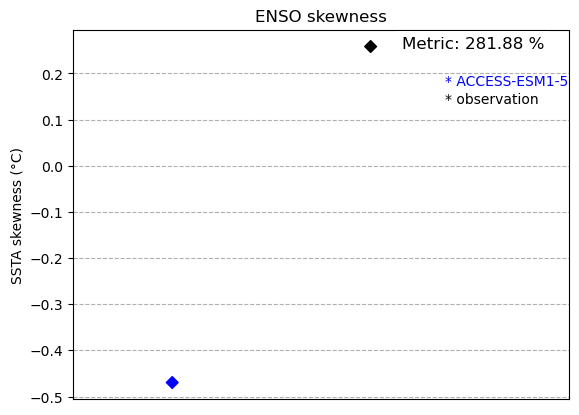

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/scipy/linalg/_basic.py:1326: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/scipy/linalg/_basic.py:1326: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:

model_skew = diag1(model_datasets_prep["ACCESS-ESM1-5"]) #sst_ske
obs_skew = diag1(obs_datasets_prep["HadISST"])

metric = [model_skew,obs_skew]


plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('SSTA skewness (°C)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO skewness')

metricval = compute(metric[1],metric[0])

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)
plt.show()

**Figure 1**: Skewness of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the expected asymmetry where positive SSTA values should typically be larger than negative SSTA values (usually close to 0). The black markers represent the reference data, while the blue markers represent the model output. The derived metric is the absolute relative difference, calculated as: \( \text{abs}((\text{model} - \text{ref}) / \text{ref}) \times 100 \).

In [15]:
def diag2(cube):
    nino34_region = {"start_longitude": 150., "end_longitude": 275., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_region(cube, **nino34_region) #
    cube = meridional_statistics(cube, 'mean')
    return cube.coord('longitude').points, skew(cube.data, axis=0)

def diag3(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -15., "end_latitude": 15.}    
    cube = extract_region(cube, **nino34_latext_region)
    skew_array = skew(cube.data, axis=0) ##2d? create cube
    new_cube = cube.collapsed('time', iris.analysis.MAX)
    new_cube.data = skew_array
    return new_cube

## Diagnostic level 2

The second level shows the zonal structure of the ENSO skewness: the skewness of the anomalies along the equator in the Pacific.

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


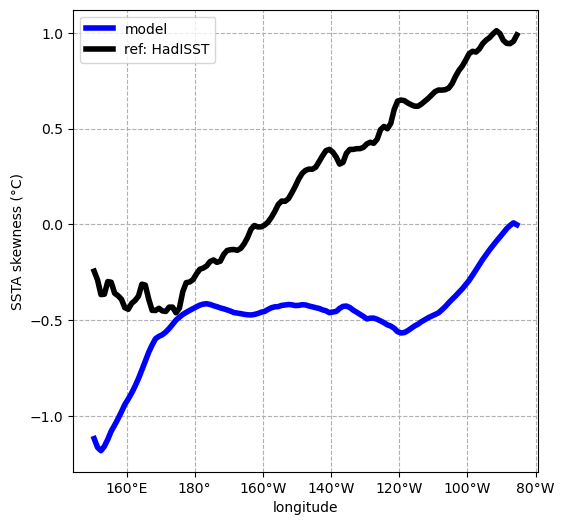

In [16]:
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

# Calculate the skew
model_skew_dev = diag2(model_datasets_prep["ACCESS-ESM1-5"]) #
obs_skew_dev = diag2(obs_datasets_prep["HadISST"])

# Create the plot
plt.figure(figsize=(6, 6))
plt.plot(*model_skew_dev, c='b', linewidth=4, label='model')
plt.plot(*obs_skew_dev, c='k', linewidth=4, label='ref: HadISST')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
# Set the x and y axis labels
plt.xlabel('longitude')
plt.ylabel('SSTA skewness (°C)')
plt.grid(linestyle='--'); plt.legend()


**Figure 2**: Zonal structure of the skewness of sea surface temperature anomalies (SSTA) in the equatorial Pacific (averaged between 5°S and 5°N), typically showing skewness close to zero in the central-eastern equatorial Pacific. The black curve represents the reference data, while the blue curve corresponds to the model output.

## Diagnostic Level 3

The third level shows the broader picture to better understand the spatial pattern of ENSO skewness: the map of the skewness of anomalies in the equatorial Pacific.

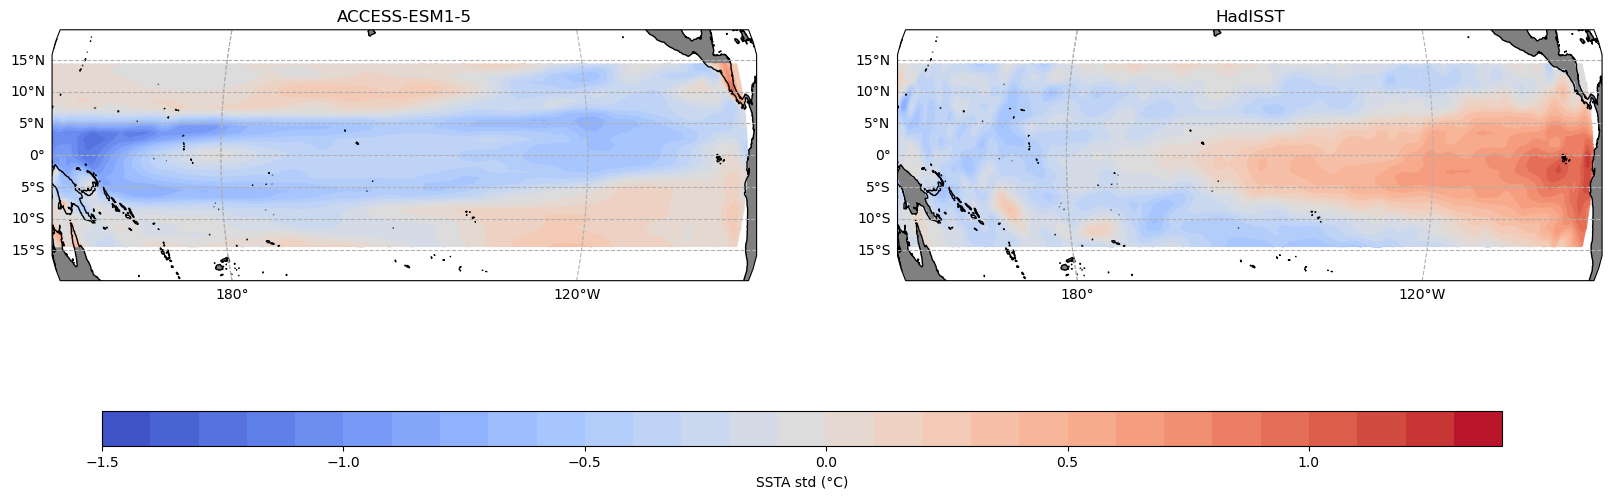

In [18]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i = 121
process = {"ACCESS-ESM1-5": diag3(model_datasets_prep["ACCESS-ESM1-5"]), 
           "HadISST": diag3(obs_datasets_prep["HadISST"])}

for label, skew_cube in process.items():
    
    ax1 = plt.subplot(i, projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(skew_cube, levels=np.arange(-1.5,1.5,0.1), cmap='coolwarm')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1.5,1.5,0.5))
cbar.set_label('SSTA std (°C)')

**Figure 3**: Spatial structure of the skewness of sea surface temperature anomalies (SSTA) in the equatorial Pacific, typically showing values too close to zero. The left map displays the reference data, while the right map shows the model output.